## Creating a Spark Session

Using Kafka consumer and producer, a data pipeline was created that reads live data from the National Rail Data Portal and sends messages for each event into our PostgreSQL database, hosted on Amazon Web Services.

The following data and alaysis is intented for scheduling prediction purposes. This report details data cleaning and analysis, focusing on...

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import DecimalType
import pandas as pd
from credentials import properties
import os

# Creating a SparkSession

spark = SparkSession \
    .builder \
    .appName("MySparkApp") \
    .config("spark.jars", "postgresql-42.7.3.jar") \
    .getOrCreate()

## Reading in data from PostgreSQL

In [2]:
df = spark.read \
    .format("jdbc") \
    .option("url", f"jdbc:postgresql://{properties['HOSTNAME']}:{properties['PORT']}/{properties['DBNAME']}") \
    .option("dbtable", "darwin") \
    .option("user", properties['USERNAME']) \
    .option("password", properties['PASS']) \
    .option("driver", "org.postgresql.Driver") \
    .load()

df.printSchema()

root
 |-- route_id: string (nullable = true)
 |-- unique_id: string (nullable = true)
 |-- service_start_date: date (nullable = true)
 |-- update_origin: string (nullable = true)
 |-- train_platform: string (nullable = true)
 |-- working_time_pass: timestamp (nullable = true)
 |-- working_time_arrival: timestamp (nullable = true)
 |-- working_time_departure: timestamp (nullable = true)
 |-- planned_time_arrival: timestamp (nullable = true)
 |-- planned_time_departure: timestamp (nullable = true)
 |-- actual_arrival_time: timestamp (nullable = true)
 |-- actual_departure_time: timestamp (nullable = true)
 |-- platform: string (nullable = true)
 |-- train_length: integer (nullable = true)
 |-- estimated_time: timestamp (nullable = true)
 |-- source: string (nullable = true)
 |-- actual_time: timestamp (nullable = true)
 |-- actual_time_class: string (nullable = true)
 |-- is_delayed_arrival: boolean (nullable = true)
 |-- is_delayed_departure: boolean (nullable = true)
 |-- source_instan

## Read in Data to Pandas

In [3]:
pandas_df = df.toPandas()
pandas_df

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_pass,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,...,platform,train_length,estimated_time,source,actual_time,actual_time_class,is_delayed_arrival,is_delayed_departure,source_instance,estimated_time_minutes
0,202407087154582,G54582,2024-07-08,TD,CRSHLTN,NaT,1970-01-01 15:48:30,1970-01-01 15:49:30,1970-01-01 15:49:00,1970-01-01 15:49:00,...,1,8.0,NaT,None,NaT,None,False,False,None,NaN
1,202407086735809,C35809,2024-07-08,TD,BRMBRK,NaT,1970-01-01 14:50:00,1970-01-01 14:50:30,1970-01-01 14:50:00,1970-01-01 14:50:00,...,1,NaN,NaT,None,NaT,None,False,False,None,NaN
2,202407086785115,C85115,2024-07-08,TD,SLOUGH,NaT,1970-01-01 14:50:30,1970-01-01 14:51:30,1970-01-01 14:51:00,1970-01-01 14:51:00,...,5,NaN,NaT,None,NaT,None,False,False,None,NaN
3,202407087145471,G45471,2024-07-08,TD,OXFD,NaT,1970-01-01 14:51:30,1970-01-01 14:52:30,1970-01-01 14:52:00,1970-01-01 14:52:00,...,4,NaN,NaT,None,NaT,None,False,False,None,NaN
4,202407087661793,L61793,2024-07-08,TD,BNTFORD,NaT,1970-01-01 14:52:00,1970-01-01 14:53:00,1970-01-01 14:52:00,1970-01-01 14:53:00,...,2,NaN,NaT,None,NaT,None,False,False,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119140,202407167659944,L59944,2024-07-16,TD,WDON,NaT,1970-01-01 14:57:30,1970-01-01 14:58:30,1970-01-01 14:58:00,1970-01-01 14:58:00,...,8,NaN,NaT,None,NaT,None,False,False,None,NaN
119141,202407167659944,L59944,2024-07-16,TD,RAYNSPK,NaT,1970-01-01 15:01:00,1970-01-01 15:01:30,1970-01-01 15:01:00,1970-01-01 15:01:00,...,3,NaN,NaT,None,NaT,None,False,False,None,NaN
119142,202407166784625,C84625,2024-07-16,CIS,TOTCTRD,NaT,1970-01-01 14:47:00,1970-01-01 14:48:00,1970-01-01 14:47:00,1970-01-01 14:48:00,...,B,NaN,NaT,None,NaT,None,False,False,None,NaN
119143,202407167139027,G39027,2024-07-16,CIS,EWELLE,NaT,1970-01-01 14:49:00,1970-01-01 14:49:30,1970-01-01 14:49:00,1970-01-01 14:49:00,...,1,5.0,NaT,None,NaT,None,False,False,None,NaN


## Check for Duplicate Values/ Nulls

To ensure quality & accuracy, certain columns containing duplicates or null values will be dropped. 


In [4]:
# Identify duplicate rows
df.groupBy(df.columns)\
    .count()\
    .where(F.col('count') > 1)\
    .select(F.sum('count'))\
    .show()

+----------+
|sum(count)|
+----------+
|      5854|
+----------+



3594 rows containing duplicates will be removed.

In [5]:
# Drop duplicates
df = df.dropDuplicates()

In [6]:
# # Null count for all columns
# Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
# Dict_Null

In [7]:
# Drop columns with too many nulls

df = df.drop('working_time_pass',\
             'pass',\
             'estimated_time',\
             'actual_time',\
             'actual_time_class',\
             'source_instance',\
             'estimated_time_minutes',\
             'train_length',\
             'source')

In [8]:
# Drop rows with too many nulls
df = df.dropna(subset='planned_time_departure')
df = df.dropna(subset='update_origin')

# Updated column count
df.count()

104565

In [9]:
from pyspark.sql.types import NumericType

def remove_outliers(df, column):
    # Get IQR
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    # Define lower and upper bounds, return
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df.filter((F.col(column) >= lower_bound) & (F.col(column) <= upper_bound))

# Get all numeric columns and remove outliers
numeric_columns = [x.name for x in df.schema.fields if isinstance(x.dataType, NumericType)]
for column in numeric_columns:
    df = remove_outliers(df, column)

In [10]:
# # Null count for all columns
# Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
# Dict_Null

## Merge Data with Rail References

SQL data is merged with RailReferences to idenfity train and station information.

In [11]:
# Import RailReferences.csv & merge with SQL data
rail_ref = spark.read.csv('RailReferences.csv', header=True, inferSchema=True)
rail_ref.printSchema()

root
 |-- AtcoCode: string (nullable = true)
 |-- TiplocCode: string (nullable = true)
 |-- CrsCode: string (nullable = true)
 |-- StationName: string (nullable = true)
 |-- StationNameLang: string (nullable = true)
 |-- GridType: string (nullable = true)
 |-- Easting: integer (nullable = true)
 |-- Northing: integer (nullable = true)
 |-- CreationDateTime: timestamp (nullable = true)
 |-- ModificationDateTime: timestamp (nullable = true)
 |-- RevisionNumber: integer (nullable = true)
 |-- Modification: string (nullable = true)



In [12]:
# Merge both DataFrames for Station Name
merged_df = df.join(rail_ref, df['train_platform'] == rail_ref['TiplocCode'], how='left')
merged_df.count()

104565

## Creating New Columns/ Feature Engineering
New columns:
- planned arrival hour
- planned departure hour
- actual arrival 
- actual depatrue hour
- arrival & depature delays in minutes
- day of week
for further analysis of train delays

In [13]:
# Create separate columns for date, time, hour
from pyspark.sql.functions import *
import datetime

# Planned arrival hour
merged_df = merged_df.withColumn('planned_arrival_hour', hour(F.col('planned_time_arrival')))

# Planned departure hour
merged_df = merged_df.withColumn('planned_dep_hour', hour(F.col('planned_time_departure')))

# Actual arrival hour
merged_df = merged_df.withColumn('actual_arrival_hour', hour(F.col('actual_arrival_time')))

# Actual departure hour
merged_df = merged_df.withColumn('actual_dep_hour', hour(F.col('actual_departure_time')))

# Calculating delay in minutes
merged_df = merged_df.withColumn('arrival_time_delayed_by', (unix_timestamp("actual_arrival_time") - unix_timestamp('planned_time_arrival'))/60)
merged_df = merged_df.withColumn('dep_time_delayed_by', (unix_timestamp("actual_departure_time") - unix_timestamp('planned_time_departure'))/60)

# Create weekday var
merged_df = merged_df.withColumn('day_of_week', date_format(F.col('service_start_date'), 'EEEE'))

# Filter by arrival time delayed & sort
merged_df.select(F.col('arrival_time_delayed_by')).filter(F.col('arrival_time_delayed_by') > 0).orderBy('arrival_time_delayed_by', ascending=False).show()

+-----------------------+
|arrival_time_delayed_by|
+-----------------------+
|                  145.0|
|                  144.0|
|                  141.0|
|                  141.0|
|                  141.0|
|                  140.0|
|                  139.0|
|                  139.0|
|                  139.0|
|                  139.0|
|                  139.0|
|                  139.0|
|                  138.0|
|                  138.0|
|                  137.0|
|                  137.0|
|                  137.0|
|                  137.0|
|                  136.0|
|                  136.0|
+-----------------------+
only showing top 20 rows



In [14]:
#merged_df.show()
merged_df.printSchema()

root
 |-- route_id: string (nullable = true)
 |-- unique_id: string (nullable = true)
 |-- service_start_date: date (nullable = true)
 |-- update_origin: string (nullable = true)
 |-- train_platform: string (nullable = true)
 |-- working_time_arrival: timestamp (nullable = true)
 |-- working_time_departure: timestamp (nullable = true)
 |-- planned_time_arrival: timestamp (nullable = true)
 |-- planned_time_departure: timestamp (nullable = true)
 |-- actual_arrival_time: timestamp (nullable = true)
 |-- actual_departure_time: timestamp (nullable = true)
 |-- platform: string (nullable = true)
 |-- is_delayed_arrival: boolean (nullable = true)
 |-- is_delayed_departure: boolean (nullable = true)
 |-- AtcoCode: string (nullable = true)
 |-- TiplocCode: string (nullable = true)
 |-- CrsCode: string (nullable = true)
 |-- StationName: string (nullable = true)
 |-- StationNameLang: string (nullable = true)
 |-- GridType: string (nullable = true)
 |-- Easting: integer (nullable = true)
 |-- N

## Convert to Pandas for Additional Exploration & Visualization

In [15]:
pandas_df = merged_df.toPandas()

In [16]:
pandas_df

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,ModificationDateTime,RevisionNumber,Modification,planned_arrival_hour,planned_dep_hour,actual_arrival_hour,actual_dep_hour,arrival_time_delayed_by,dep_time_delayed_by,day_of_week
0,202407086746668,C46668,2024-07-08,TD,DONC,1970-01-01 14:08:00,1970-01-01 14:10:00,1970-01-01 14:08:00,1970-01-01 14:10:00,NaT,...,2010-12-20 15:37:54,2.0,rev,14.0,14,NaN,14.0,NaN,44.0,Monday
1,202407086765055,C65055,2024-07-08,Darwin,PELAWTW,1970-01-01 14:07:00,1970-01-01 14:07:30,1970-01-01 14:07:00,1970-01-01 14:07:00,1970-01-01 15:10:00,...,NaT,NaN,None,14.0,14,15.0,15.0,63.0,63.0,Monday
2,202407088094162,P94162,2024-07-08,Trust,CLPHHS,1970-01-01 14:52:30,1970-01-01 14:53:00,1970-01-01 14:53:00,1970-01-01 14:53:00,1970-01-01 14:53:00,...,2006-09-18 18:24:34,1.0,rev,14.0,14,14.0,14.0,0.0,1.0,Monday
3,202407088097455,P97455,2024-07-08,Darwin,CRNG,1970-01-01 22:14:00,1970-01-01 22:14:30,1970-01-01 22:14:00,1970-01-01 22:14:00,1970-01-01 22:15:00,...,2006-09-18 18:24:34,1.0,rev,22.0,22,22.0,22.0,1.0,1.0,Monday
4,202407088090877,P90877,2024-07-08,TD,HOMRTON,1970-01-01 22:12:30,1970-01-01 22:13:00,1970-01-01 22:13:00,1970-01-01 22:13:00,1970-01-01 22:14:00,...,2010-05-14 17:37:23,2.0,rev,22.0,22,22.0,22.0,1.0,1.0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104560,202407167139298,G39298,2024-07-16,TD,CLPHMJC,1970-01-01 14:14:00,1970-01-01 14:15:00,1970-01-01 14:14:00,1970-01-01 14:15:00,1970-01-01 14:14:00,...,2007-11-14 16:23:42,2.0,rev,14.0,14,14.0,14.0,0.0,0.0,Tuesday
104561,202407166760778,C60778,2024-07-16,TD,STKP,1970-01-01 14:24:30,1970-01-01 14:25:30,1970-01-01 14:25:00,1970-01-01 14:25:00,1970-01-01 15:10:00,...,2006-09-18 18:24:34,1.0,rev,14.0,14,15.0,15.0,45.0,46.0,Tuesday
104562,202407167131994,G31994,2024-07-16,Trust,DARNALL,1970-01-01 14:45:00,1970-01-01 14:45:30,1970-01-01 14:45:00,1970-01-01 14:45:00,NaT,...,2008-10-28 10:01:31,2.0,rev,14.0,14,NaN,NaN,NaN,NaN,Tuesday
104563,202407166735286,C35286,2024-07-16,CIS,OLDROAN,1970-01-01 14:48:30,1970-01-01 14:49:00,1970-01-01 14:49:00,1970-01-01 14:49:00,1970-01-01 14:49:00,...,2006-09-18 18:24:34,1.0,rev,14.0,14,14.0,14.0,0.0,0.0,Tuesday


## Adjusting StationName Column for Better Readibility

With nulls in the StationName column, we filled those with their respective train platforms

In [17]:
# Fill null Station Names with its respective Train Platform
pandas_df['StationName'] = pandas_df['StationName'].fillna(pandas_df['train_platform'])

Each station's name read "Rail Station" at the end. Those were eliminated for redundency and readability.

In [18]:
# Eliminate "Rail Station" for better readibility
pandas_df['StationName'] = pandas_df['StationName'].str.replace(' Rail Station', '')


## Creating Latitude & Longitude Columns

For further analysis with weather, the Easting & Northing columns were converted to obtain the proper weather data. By obtaining latitude and longitude data, we can analyze train delays at precise geographical locations, visualize patterns, and identify regions where trains might be delayed due to weather conditions. This allows for operational improvements, such as resource allocation and scheduling adjustments, to be planned and adjusted in anticipation of future weather impacts.

In [19]:
# Drop nulls before conversion
pandas_df = pandas_df.dropna(subset=['Easting', 'Northing'])

In [20]:
# Define data from the National British Grid
from pyproj import Proj

# British National Grid (EPSG:27700)
bng = Proj('epsg:27700')
# WGS84 (EPSG:4326)
wgs84 = Proj('epsg:4326')

In [21]:
# Define the transformer for converting BNG to WGS84
from pyproj import Transformer

transformer = Transformer.from_crs("epsg:27700", "epsg:4326")

In [22]:
# Convert Easting & Northing to latitude & longitude
def convert_to_latlon(easting, northing):
    longitude, latitude = transformer.transform(easting, northing)
    return longitude, latitude

In [52]:
# Convert easting/northing to lat/lon and store in DataFrame
pandas_df[['Latitude', 'Longitude']] = pandas_df.apply(lambda row: pd.Series(convert_to_latlon(row['Easting'], row['Northing'])), axis=1)

/tmp/ipykernel_948/1293387366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df[['Latitude', 'Longitude']] = pandas_df.apply(lambda row: pd.Series(convert_to_latlon(row['Easting'], row['Northing'])), axis=1)


In [53]:
pandas_df[['Latitude', 'Longitude']]

,Latitude,Longitude
0,53.522148,-1.139845
2,51.465479,-0.132522
3,51.208098,0.790331
4,51.547010,-0.042360
6,51.504386,-0.055931
...,...,...
104560,51.464186,-0.170279
104561,53.405537,-2.163013
104562,53.384583,-1.412567
104563,53.486893,-2.951071


**Categorizing longitude & latitude columns into regions**

In [54]:
# Region boundaries
northern = 54.5  # Approx. above Yorkshire
southern = 51.0  # Approx. below London
eastern = -0.5   # East of the Prime Meridian
western = -3.0   # West of the Prime Meridian

# Function to categorize regions
def categorize_region(lat, lon):
    if lat >= northern:
        return 'Northern'
    elif lat < southern:
        return 'Southern'
    elif lon >= eastern:
        return 'Eastern'
    elif lon < western:
        return 'Western'
    else:
        return 'Central'

# Apply region categorization to DataFrame
pandas_df['Region'] = pandas_df.apply(lambda row: categorize_region(row['Latitude'], row['Longitude']), axis=1)


/tmp/ipykernel_948/3199536503.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['Region'] = pandas_df.apply(lambda row: categorize_region(row['Latitude'], row['Longitude']), axis=1)


In [56]:
pandas_df['Region'].unique()

array(['Central', 'Eastern', 'Southern', 'Northern', 'Western'],
      dtype=object)

## Describe/ Explore Data

After cleaning the data, the following Data Dictionary defines what will be analyzed:

**Data Dictionary**
- route_id: The unique identifier for each train route.
- unique_id: The unique identifier for each train
- service_start_date: The date when the train service for the particular route started.
- update_origin: Source or system from which the data was updated or retrieved.
- train_platform: The short name for a station where the train arrives and departs.
- working_time_arrival: The planned or scheduled time for the train to arrive at a station.
- working_time_departure: The planned or scheduled time for the train to depart from a station.
- planned_time_arrival: The officially planned time for the train to arrive at a station. This could be the public-facing scheduled time.
- planned_time_departure: The officially planned time for the train to depart from a station. This could be the public-facing scheduled time.
- platform: The platform number at the station where the train arrives and departs.
- actual_arrival_time: The actual time when the train arrived at a station.
- actual_departure_time: The actual time when the train departed from a station.
- is_delayed_arrival: A boolean flag indicating whether the train arrived late
- is_delayed_departure: A boolean flag indicating whether the train departed late from a station.

In [26]:
# create new df with route_id, unique_id, StationName, isDelayed
delayed_df = pandas_df[pandas_df['is_delayed_departure'] == True]
delayed_df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,planned_arrival_hour,planned_dep_hour,actual_arrival_hour,actual_dep_hour,arrival_time_delayed_by,dep_time_delayed_by,day_of_week,Latitude,Longitude,Region
9,202407088082098,P82098,2024-07-08,TD,KRKH,1970-01-01 16:51:30,1970-01-01 16:52:00,1970-01-01 16:52:00,1970-01-01 16:52:00,1970-01-01 17:00:00,...,16.0,16,17.0,17.0,8.0,8.0,Monday,NaN,NaN,Central
10,202407087136551,G36551,2024-07-08,Darwin,HBDNBDG,1970-01-01 22:37:00,1970-01-01 22:38:00,1970-01-01 22:37:00,1970-01-01 22:38:00,1970-01-01 22:44:00,...,22.0,22,22.0,22.0,7.0,7.0,Monday,NaN,NaN,Central
31,202407088080672,P80672,2024-07-08,Darwin,SHWLNDS,1970-01-01 17:33:30,1970-01-01 17:34:00,1970-01-01 17:34:00,1970-01-01 17:34:00,1970-01-01 17:34:00,...,17.0,17,17.0,17.0,0.0,0.0,Monday,NaN,NaN,Central
45,202407087144904,G44904,2024-07-08,Darwin,NTHCAMP,1970-01-01 22:40:30,1970-01-01 22:41:30,1970-01-01 22:41:00,1970-01-01 22:41:00,1970-01-01 23:08:00,...,22.0,22,23.0,23.0,27.0,28.0,Monday,NaN,NaN,Central
54,202407097131002,G31002,2024-07-09,CIS,ARMTHWT,1970-01-01 17:43:30,1970-01-01 17:44:30,1970-01-01 17:44:00,1970-01-01 17:44:00,1970-01-01 17:44:00,...,17.0,17,17.0,17.0,0.0,0.0,Tuesday,NaN,NaN,Central


## Analysis 1: 
## What hour or the day & week are most trains most frequently delayed?
Here, we analzye the distribution of departing trains cateogrized by the hour of the day and day of the week

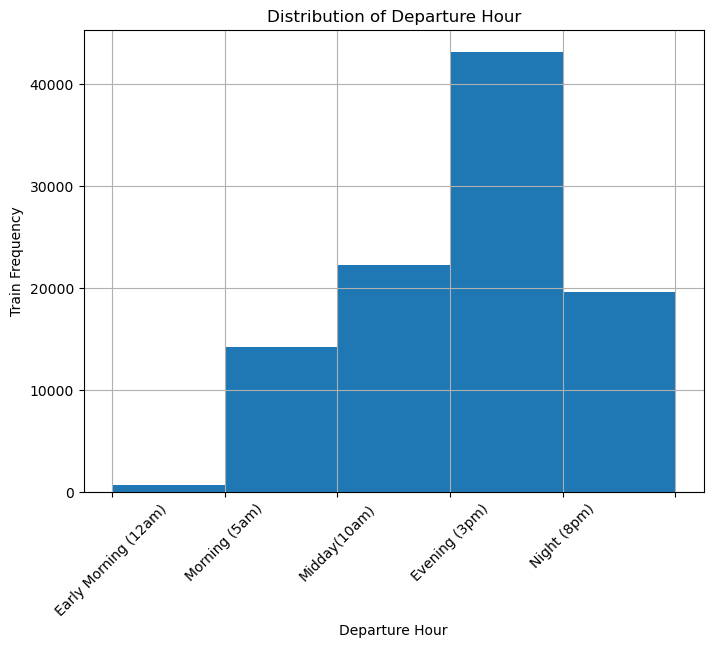

In [27]:
# create distributions 
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0, 5, 10, 15, 20, 25]
labels = ['Early Morning (12am)', 'Morning (5am)', 'Midday(10am)', 'Evening (3pm)', 'Night (8pm)', ' ']

plt.figure(figsize=(8, 6))
plt.hist(pandas_df['planned_dep_hour'], bins=bins)
plt.title('Distribution of Departure Hour')
plt.xlabel('Departure Hour')
plt.ylabel('Train Frequency')
plt.xticks(bins, labels, rotation=45)
plt.grid()
plt.show()

Train departures are most frequent during the evening (3pm-7pm) and night (8pm-11pm) periods. This increased volume of departures during these times could potentially contribute to a higher likelihood of delays.

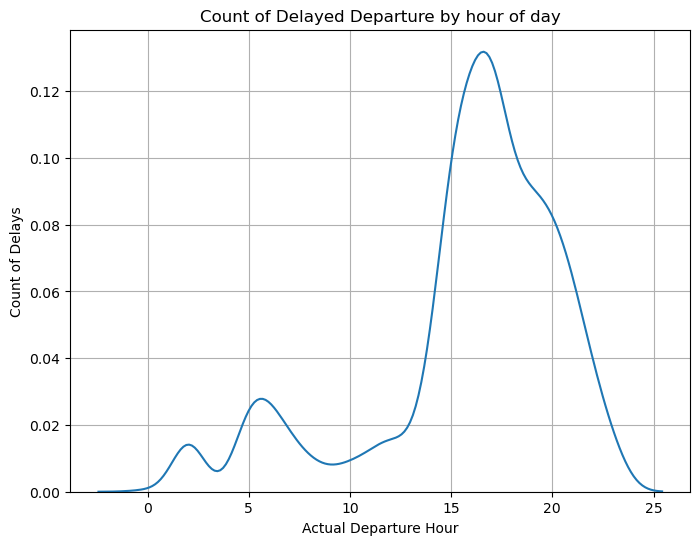

In [28]:
plt.figure(figsize=(8,6))
sns.kdeplot(delayed_df['actual_dep_hour'])
plt.title('Count of Delayed Departure by hour of day')
plt.xlabel('Actual Departure Hour')
plt.ylabel('Count of Delays')
plt.grid()
plt.show()

## Delays by Day of Week

Categorizing delays by the day of the week allows us to determine if delays are more frequent on certain days or if specific days consistently experience higher delays. Such inforamtion can be useful for future scheudling purposes such as adding more buffer time to mitigate dealys or increase resources, such as number of tains running and availability of staff & maintenence workers.

**Day of Week Distribution**

In [29]:
# plt.figure(figsize=(10, 6))
# day_dist = pandas_df['day_of_week'].value_counts()
# sns.barplot(x=day_dist.index, y=day_dist.values)
# plt.title('Day of Week Distribution')
# plt.xlabel('Day')
# plt.ylabel('Count')
# plt.xticks(rotation=90)
# plt.show()


Most trains run Wednesday and Thursday, with the least amount of trains running on Saturday.

**Hour & day of week distribution**

In [30]:
# # Define bins and labels for departure hours
# bins = [0, 5, 10, 15, 20, 25]
# labels = ['Early Morning (12am)', 'Morning (5am)', 'Midday (10am)', 'Afternoon (3pm)', 'Evening (8pm)']

# # Pivot table to count frequencies of dep_hour_category by day_of_week
# heatmap_data = pandas_df.pivot_table(index='day_of_week', columns='dep_hour_category', aggfunc='size', fill_value=0)

# plt.figure(figsize=(12, 8))
# sns.heatmap(heatmap_data.loc[days_order], cmap='coolwarm', annot=True, fmt='d', cbar=True)
# plt.title('Frequency of Departure Hour by Day of Week')
# plt.xlabel('Departure Hour')
# plt.ylabel('Day of Week')
# plt.xticks(rotation=45)

# plt.show()

## Analysis 1: Conclusion:

Busiest days: Wednesday & Friday have the highest frequency of train departures.
Least busy days: The weekends run the least amount of departures.

Peak hours:
- Monday: shows a distinct pattern with a high number of departures in the afternoon (3pm-8pm) and evening (8pm-12am) but almost none in the morning (5am-10am).
- Tuesday:
- Wednesday:
- Thursday:
- Friday:
These patterns indicate that train departure schedules are highly concentrated on weekdays during afternoon and evening hours, which could be reflective of peak travel times. 

OVer time, as more data is collected, it can be analyzed for more accruate delayed arrival and departures. 

In [31]:
# create new df with route_id, unique_id, StationName, isDelayed
delayed_df = pandas_df[pandas_df['is_delayed_departure'] == True]
delayed_df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,planned_arrival_hour,planned_dep_hour,actual_arrival_hour,actual_dep_hour,arrival_time_delayed_by,dep_time_delayed_by,day_of_week,Latitude,Longitude,Region
9,202407088082098,P82098,2024-07-08,TD,KRKH,1970-01-01 16:51:30,1970-01-01 16:52:00,1970-01-01 16:52:00,1970-01-01 16:52:00,1970-01-01 17:00:00,...,16.0,16,17.0,17.0,8.0,8.0,Monday,NaN,NaN,Central
10,202407087136551,G36551,2024-07-08,Darwin,HBDNBDG,1970-01-01 22:37:00,1970-01-01 22:38:00,1970-01-01 22:37:00,1970-01-01 22:38:00,1970-01-01 22:44:00,...,22.0,22,22.0,22.0,7.0,7.0,Monday,NaN,NaN,Central
31,202407088080672,P80672,2024-07-08,Darwin,SHWLNDS,1970-01-01 17:33:30,1970-01-01 17:34:00,1970-01-01 17:34:00,1970-01-01 17:34:00,1970-01-01 17:34:00,...,17.0,17,17.0,17.0,0.0,0.0,Monday,NaN,NaN,Central
45,202407087144904,G44904,2024-07-08,Darwin,NTHCAMP,1970-01-01 22:40:30,1970-01-01 22:41:30,1970-01-01 22:41:00,1970-01-01 22:41:00,1970-01-01 23:08:00,...,22.0,22,23.0,23.0,27.0,28.0,Monday,NaN,NaN,Central
54,202407097131002,G31002,2024-07-09,CIS,ARMTHWT,1970-01-01 17:43:30,1970-01-01 17:44:30,1970-01-01 17:44:00,1970-01-01 17:44:00,1970-01-01 17:44:00,...,17.0,17,17.0,17.0,0.0,0.0,Tuesday,NaN,NaN,Central


**Day of Week Distribution**

**Creating a Weekday Data Frame to plot**

In [32]:
weekday_df = delayed_df.groupby('day_of_week').mean(numeric_only=True).reset_index()

# Calculate total trains per day
total_trains_df = pandas_df.groupby('day_of_week').size().reset_index(name='total_trains')

# Calculate delayed trains per day
delayed_trains_df = pandas_df[pandas_df['is_delayed_departure'] == True].groupby('day_of_week').size().reset_index(name='delayed_trains')

# Merge the DataFrames
proportion_df = pd.merge(total_trains_df, delayed_trains_df, on='day_of_week', how='left')

# Calculate the proportion of delayed trains
proportion_df['proportion_delayed'] = proportion_df['delayed_trains'] / proportion_df['total_trains']

# Fill NaN values in delayed_trains column with 0
proportion_df['delayed_trains'] = proportion_df['delayed_trains'].fillna(0)
proportion_df['proportion_delayed'] = proportion_df['delayed_trains'] / proportion_df['total_trains']

In [33]:
# Defining the order of the days of the week
days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Creating a categorical column to ensure the correct order of the days
proportion_df['day_of_week'] = pd.Categorical(proportion_df['day_of_week'], categories=days_order, ordered=True)

# Sort DataFrame by 'day' column
proportion_df = proportion_df.sort_values('day_of_week') 
proportion_df

,day_of_week,total_trains,delayed_trains,proportion_delayed
3,Sunday,1833,298.0,0.162575
1,Monday,20284,1655.0,0.081591
5,Tuesday,30598,1914.0,0.062553
6,Wednesday,18685,1013.0,0.054215
4,Thursday,14949,696.0,0.046558
0,Friday,13684,2042.0,0.149225
2,Saturday,8,0.0,0.000000


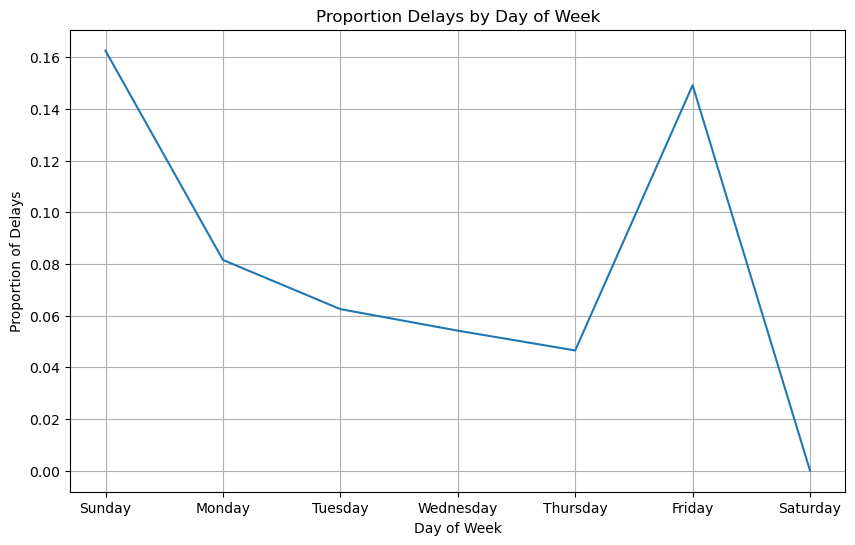

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.lineplot(data=proportion_df, x='day_of_week', y='proportion_delayed')
plt.title('Proportion Delays by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Proportion of Delays')
plt.grid()
plt.show()

## Analysis 2: Stations with the most delays

**Top 10 most Frequently Visited Stations**

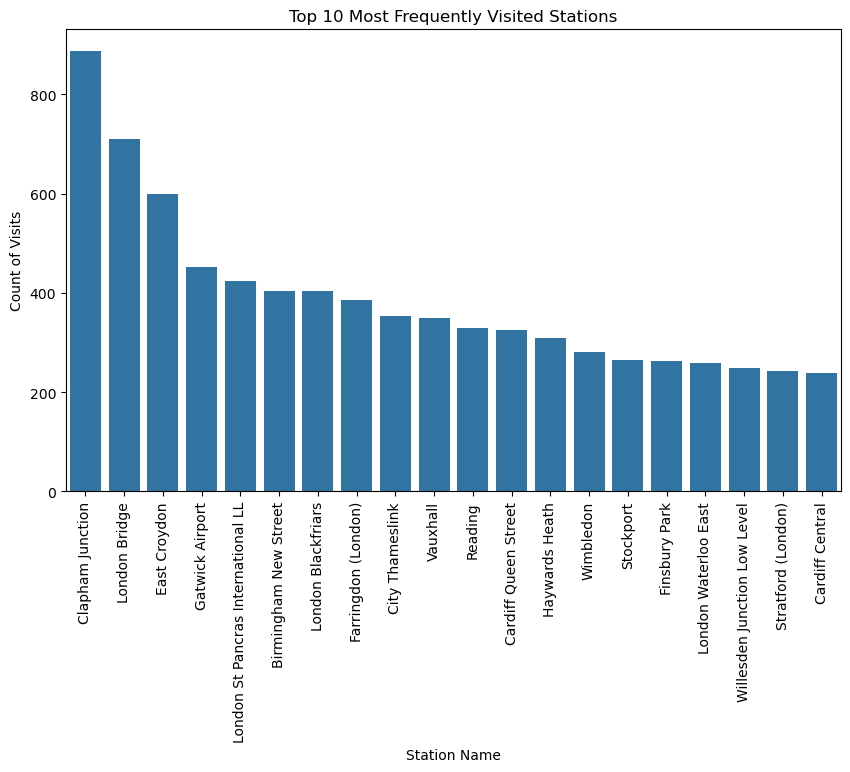

In [35]:
top_10_stations = pandas_df['StationName'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_stations.index, y=top_10_stations.values)
plt.title('Top 10 Most Frequently Visited Stations')
plt.xlabel('Station Name')
plt.ylabel('Count of Visits')
plt.xticks(rotation=90)
plt.show()

Claphman Junction is the most frequently visited station.

**Top 10 stations with most delays**

In [36]:
result = pandas_df.groupby('StationName')['dep_time_delayed_by'].sum().reset_index()
result = result.sort_values(by='dep_time_delayed_by', ascending=False)
result.head(10)

,StationName,dep_time_delayed_by
2267,Willesden Junction Low Level,6987.0
964,Harlesden,6963.0
2007,Sunderland,4779.0
399,Cardiff Central,4588.0
400,Cardiff Queen Street,4345.0
2099,Trefforest,3952.0
1658,Pontypridd,3879.0
892,Grangetown (Cardiff),3126.0
1148,Kensal Green,3086.0
2,Abercynon,2626.0


**Top 10 stations with count of delayed departures**

In [37]:
# Find top 10 stations with most delays
result = pandas_df[pandas_df['is_delayed_departure'] == True].groupby('StationName')['is_delayed_departure'].count().reset_index()
result = result.sort_values(by='is_delayed_departure', ascending=False)
result.head(10)

,StationName,is_delayed_departure
211,Cardiff Queen Street,101
525,Harlesden,101
1219,Willesden Junction Low Level,101
210,Cardiff Central,80
1125,Trefforest,79
902,Pontypridd,78
924,Radyr,77
1126,Trefforest Estate,77
1092,Taffs Well,77
1075,Sunderland,73


In [38]:
pandas_df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,planned_arrival_hour,planned_dep_hour,actual_arrival_hour,actual_dep_hour,arrival_time_delayed_by,dep_time_delayed_by,day_of_week,Latitude,Longitude,Region
0,202407086746668,C46668,2024-07-08,TD,DONC,1970-01-01 14:08:00,1970-01-01 14:10:00,1970-01-01 14:08:00,1970-01-01 14:10:00,NaT,...,14.0,14,NaN,14.0,NaN,44.0,Monday,NaN,NaN,Central
2,202407088094162,P94162,2024-07-08,Trust,CLPHHS,1970-01-01 14:52:30,1970-01-01 14:53:00,1970-01-01 14:53:00,1970-01-01 14:53:00,1970-01-01 14:53:00,...,14.0,14,14.0,14.0,0.0,1.0,Monday,NaN,NaN,Central
3,202407088097455,P97455,2024-07-08,Darwin,CRNG,1970-01-01 22:14:00,1970-01-01 22:14:30,1970-01-01 22:14:00,1970-01-01 22:14:00,1970-01-01 22:15:00,...,22.0,22,22.0,22.0,1.0,1.0,Monday,NaN,NaN,Central
4,202407088090877,P90877,2024-07-08,TD,HOMRTON,1970-01-01 22:12:30,1970-01-01 22:13:00,1970-01-01 22:13:00,1970-01-01 22:13:00,1970-01-01 22:14:00,...,22.0,22,22.0,22.0,1.0,1.0,Monday,NaN,NaN,Central
6,202407088094180,P94180,2024-07-08,TD,WAPPING,1970-01-01 16:44:00,1970-01-01 16:44:30,1970-01-01 16:44:00,1970-01-01 16:44:00,NaT,...,16.0,16,NaN,NaN,NaN,NaN,Monday,NaN,NaN,Central


**Top 10 Stations delayed by average minutes**

In [39]:
avg_delays = pandas_df.groupby('StationName')[['arrival_time_delayed_by', 'dep_time_delayed_by']].mean().reset_index()
avg_delays = avg_delays.sort_values(by=['arrival_time_delayed_by', 'dep_time_delayed_by'], ascending=False)
avg_delays.head(10)

,StationName,arrival_time_delayed_by,dep_time_delayed_by
1984,Stonebridge Park,42.863636,-56.839286
964,Harlesden,41.562874,37.037234
2007,Sunderland,39.453782,35.664179
628,Dingle Road,37.444444,37.236364
2267,Willesden Junction Low Level,34.989848,30.915929
1762,Rotherham Central,34.466667,32.123077
1201,Kiveton Park,33.833333,26.000000
598,Darnall,31.800000,23.222222
318,Brockley Whins,30.029412,27.837838
1148,Kensal Green,29.617647,25.716667


## Analysis 3: Correlations between Stations and their Delays

The following correlation analyses will help us understand the relationship between our numeric variables

**Delay Correlation Analysis**

In [40]:
# Analyze correlations between features and delay columns
correlation_matrix = pandas_df.corr(numeric_only=True)
# Display the correlations with delay columns
delay_correlations = correlation_matrix[['arrival_time_delayed_by', 'dep_time_delayed_by']].sort_values(by='arrival_time_delayed_by', ascending=False)
# Display the top correlations
delay_correlations.head()

,arrival_time_delayed_by,dep_time_delayed_by
arrival_time_delayed_by,1.000000,0.999737
dep_time_delayed_by,0.999737,1.000000
is_delayed_departure,0.174174,0.159789
is_delayed_arrival,0.174107,0.164653
actual_dep_hour,0.080008,0.081488


While arrival and delay have the strongest correlation, that is anticipated, as if a train was arriving late, it would liekly be departing late as well. This correlation is not 

**Comprehensive Correlation Analysis**

In [41]:
# Calculate the correlation matrix for the dataset
correlation_matrix = pandas_df.corr(numeric_only=True)

# Sort the correlation values to find the highest correlations
correlation_sorted = correlation_matrix.abs().unstack().sort_values(ascending=False)

# Remove self-correlations (correlation of a feature with itself)
correlation_sorted = correlation_sorted[correlation_sorted < 1]

# Display the highest correlations
correlation_sorted.head(10)

dep_time_delayed_by      arrival_time_delayed_by    0.999737
arrival_time_delayed_by  dep_time_delayed_by        0.999737
planned_arrival_hour     planned_dep_hour           0.999611
planned_dep_hour         planned_arrival_hour       0.999611
actual_dep_hour          actual_arrival_hour        0.999555
actual_arrival_hour      actual_dep_hour            0.999555
planned_arrival_hour     actual_arrival_hour        0.991701
actual_arrival_hour      planned_arrival_hour       0.991701
actual_dep_hour          planned_dep_hour           0.991664
planned_dep_hour         actual_dep_hour            0.991664
dtype: float64

**Correlation Matrix**

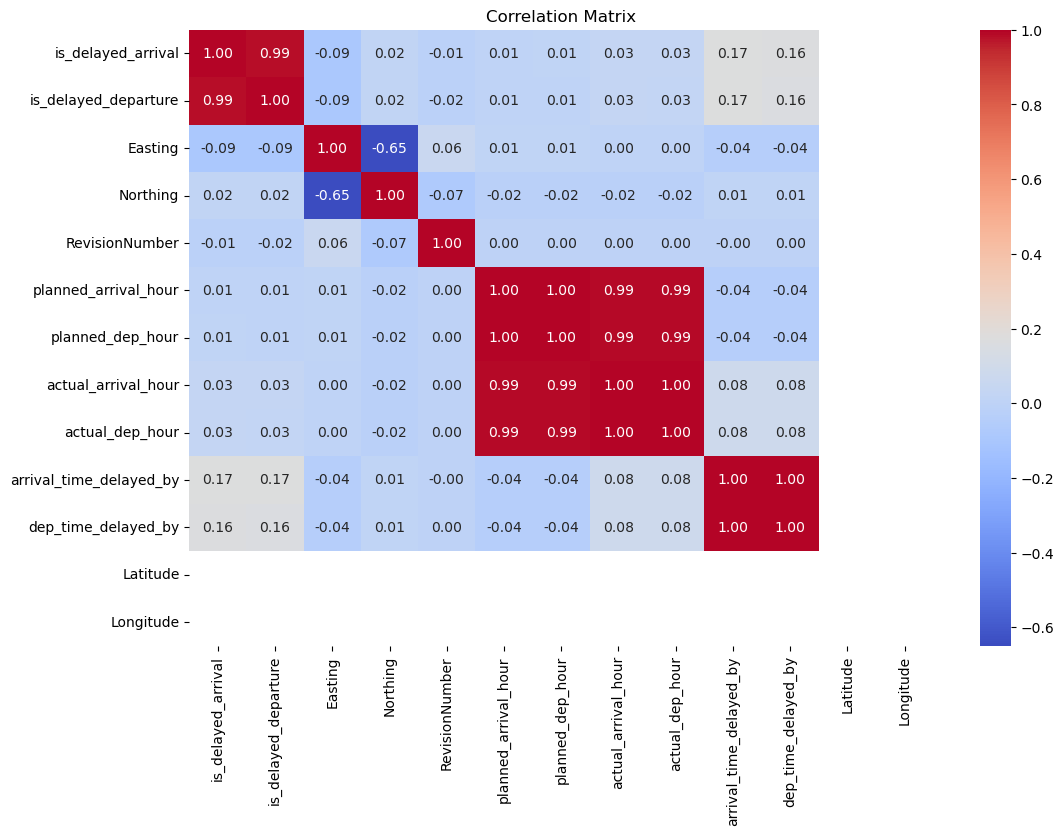

In [42]:
# Visual: Correlation Heat Map:
corr_map = pandas_df[['planned_arrival_hour', 'planned_dep_hour','actual_arrival_hour', 'actual_dep_hour', 'Latitude', 'Longitude']]
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Delayed arrived and delayed departures are highly correlated, while geospatial features such as Easting and Northing have low correlation with delays. Such geospatial features will not be useful to analyze further

## Logistic Regression
Created a LR Model to predict if the train departure will be delayed

In [43]:
# # logistic regression:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from sklearn.preprocessing import OneHotEncoder
# import pandas as pd

# # Select relevant columns and drop null rows
# vars = pandas_df[['train_platform', 'planned_arrival_hour', 'planned_dep_hour', 'is_delayed_departure']].dropna()

# # Convert booleans to floats
# vars['is_delayed_departure'] = vars['is_delayed_departure'].astype('float')
# vars['planned_dep_hour'] = vars['planned_dep_hour'].astype('float')

# # One-hot encoding for the categorical 'platform' column
# vars = pd.get_dummies(vars, columns=['train_platform'], dtype='float')

# # X = all columns except 'is_delayed_departure'
# X = vars.drop('is_delayed_departure', axis=1)
# y = vars['is_delayed_departure']

# # Split Data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
# # Train Model
# log_reg = LogisticRegression(random_state=42, max_iter=10000)
# log_reg.fit(X_train, y_train)

In [45]:
# # Evaluate Model
# y_pred = log_reg.predict(X_test)

# # Define report, confusion matrix, and accuracy
# report = classification_report(y_test, y_pred)
# cm = confusion_matrix(y_test, y_pred)
# accuracy = accuracy_score(y_test, y_pred)

# # Display results
# print(f"Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)
# print("Confusion Matrix:\n", cm)

**The model correctly predicted the negative class:**
- True Negatives = 12,704
- False Positives = 19 \
**The model correctly predicted the positive class:**
- True Positives = 40
- False Negatives = 924

In [46]:
# # Visual: confusion matrix

# import matplotlib.pyplot as plt
# import seaborn as sns
# cm = confusion_matrix(y_test, y_pred)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

## Export DataFrame to PowerBi for Further Visualizations

In [47]:
pandas_df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,planned_arrival_hour,planned_dep_hour,actual_arrival_hour,actual_dep_hour,arrival_time_delayed_by,dep_time_delayed_by,day_of_week,Latitude,Longitude,Region
0,202407086746668,C46668,2024-07-08,TD,DONC,1970-01-01 14:08:00,1970-01-01 14:10:00,1970-01-01 14:08:00,1970-01-01 14:10:00,NaT,...,14.0,14,NaN,14.0,NaN,44.0,Monday,NaN,NaN,Central
2,202407088094162,P94162,2024-07-08,Trust,CLPHHS,1970-01-01 14:52:30,1970-01-01 14:53:00,1970-01-01 14:53:00,1970-01-01 14:53:00,1970-01-01 14:53:00,...,14.0,14,14.0,14.0,0.0,1.0,Monday,NaN,NaN,Central
3,202407088097455,P97455,2024-07-08,Darwin,CRNG,1970-01-01 22:14:00,1970-01-01 22:14:30,1970-01-01 22:14:00,1970-01-01 22:14:00,1970-01-01 22:15:00,...,22.0,22,22.0,22.0,1.0,1.0,Monday,NaN,NaN,Central
4,202407088090877,P90877,2024-07-08,TD,HOMRTON,1970-01-01 22:12:30,1970-01-01 22:13:00,1970-01-01 22:13:00,1970-01-01 22:13:00,1970-01-01 22:14:00,...,22.0,22,22.0,22.0,1.0,1.0,Monday,NaN,NaN,Central
6,202407088094180,P94180,2024-07-08,TD,WAPPING,1970-01-01 16:44:00,1970-01-01 16:44:30,1970-01-01 16:44:00,1970-01-01 16:44:00,NaT,...,16.0,16,NaN,NaN,NaN,NaN,Monday,NaN,NaN,Central


In [57]:
pandas_df.to_csv('rail_data_eda.csv', index=False)